In [21]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import keras_tuner
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
tf.keras.backend.clear_session()
seed = 9
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)


# Data loading and preprocessing

In [23]:
#load the fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#normalise the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Building a model through hyperparameter tuning

In [24]:
def model_builder(hp):
    # Create a Sequential model
    model = Sequential()
    
    #flatten the input images
    model.add(Flatten(input_shape=(28,28)))
    
    #define hyperparameter values to search for the optimum  
    activation_param = hp.Choice('activation', values=['relu', 'tanh'])
    layer1_param = hp.Int('layer1', min_value=100, max_value=1000, step=100)
    layer2_param = hp.Int('layer2', min_value=100, max_value=1000, step=100)
    lr_param = hp.Choice('learning_rate', values= [0.001, 0.0005, 0.0001])
    optimizer_param = hp.Choice('optimizer', values=['adam', 'nadam', 'sgd', 'rmsprop'])
    
    
    #add dense layers to the model with values from the hyperparameter space
    model.add(Dense(units=layer1_param, activation=activation_param))
    model.add(Dense(units=layer2_param, activation=activation_param))
    model.add(Dense(10, activation='softmax'))
    
    # Define optimizers based on the hyperparameter choice
    if optimizer_param == 'adam':
        optimizer = Adam(learning_rate=lr_param)
    elif optimizer_param == 'nadam':
        optimizer = Nadam(learning_rate=lr_param)
    elif optimizer_param == 'sgd':
        optimizer = SGD(learning_rate=lr_param)
    else:
        optimizer = RMSprop(learning_rate=lr_param)
    
    # Compile the model with the selected optimizer
    model.compile(optimizer=optimizer, 
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model

In [25]:
# Create a Hyperband tuner for hyperparameter optimization
tuner = keras_tuner.Hyperband(
    model_builder,             # call our function to build the model
    objective='val_accuracy',  # define metric to optimize
    max_epochs=4,             # Max number of training epochs per model
    factor=3,                  
    directory='dir',           
    project_name='hband_tuner'           
)


In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # Adjust the settings as needed

log_dir = "./dir/x/tb_logs"  # Change this to your desired log directory
tensorboard_callback = TensorBoard(log_dir=log_dir)

In [27]:
# use Hyperband tuner to search for the best hyperparameters
tuner.search(
    X_train,                    # Training data
    y_train,                    # Training labels
    epochs=3,                  # Max number of training epochs per model
    validation_split=0.2,       # Fraction of training data used for validation
    callbacks=[early_stop,tensorboard_callback]      # define callback as our early stop method
)


Trial 10 Complete [00h 00m 45s]
val_accuracy: 0.8071666955947876

Best val_accuracy So Far: 0.8839166760444641
Total elapsed time: 00h 07m 21s


In [28]:
%load_ext tensorboard
%tensorboard --logdir log_dir

Reusing TensorBoard on port 6006 (pid 15936), started 21:46:21 ago. (Use '!kill 15936' to kill it.)

In [29]:
best_params = tuner.get_best_hyperparameters(num_trials=1)[0] #get the best performing hyperparameters

# List of hyperparameters to iterate through
hyperparameter_names = ['activation', 'layer1', 'layer2', 'learning_rate', 'optimizer']

# Iterate through the list and display the best values
print("Best Hyperparameters:")
for param_name in hyperparameter_names:
    param_value = best_params.get(param_name)
    print(f"{param_name.capitalize()}: {param_value}")

Best Hyperparameters:
Activation: tanh
Layer1: 500
Layer2: 500
Learning_rate: 0.0005
Optimizer: nadam


In [30]:
#build model with best params
best_model = tuner.hypermodel.build(best_params) 

#train best model on the train data
history = best_model.fit(X_train, y_train, epochs=35, validation_split=0.15, callbacks=[early_stop]) 

Epoch 1/35
1594/1594 [==============================] - 17s 10ms/step - loss: 0.4722 - accuracy: 0.8298 - val_loss: 0.3906 - val_accuracy: 0.8564
Epoch 2/35
1594/1594 [==============================] - 15s 10ms/step - loss: 0.3675 - accuracy: 0.8657 - val_loss: 0.3620 - val_accuracy: 0.8661
Epoch 3/35
1594/1594 [==============================] - 16s 10ms/step - loss: 0.3277 - accuracy: 0.8795 - val_loss: 0.3475 - val_accuracy: 0.8743
Epoch 4/35
1594/1594 [==============================] - 16s 10ms/step - loss: 0.2995 - accuracy: 0.8884 - val_loss: 0.3452 - val_accuracy: 0.8729
Epoch 5/35
1594/1594 [==============================] - 16s 10ms/step - loss: 0.2805 - accuracy: 0.8949 - val_loss: 0.3201 - val_accuracy: 0.8813
Epoch 6/35
1594/1594 [==============================] - 16s 10ms/step - loss: 0.2607 - accuracy: 0.9016 - val_loss: 0.3408 - val_accuracy: 0.8771
Epoch 7/35
1594/1594 [==============================] - 15s 10ms/step - loss: 0.2446 - accuracy: 0.9076 - val_loss: 0.3017 -

In [31]:
#evaluate best model on the test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.3318 - accuracy: 0.8816
Test Accuracy: 88.16%
Test Loss: 0.3318


In [32]:
history_df = pd.DataFrame(history.history)

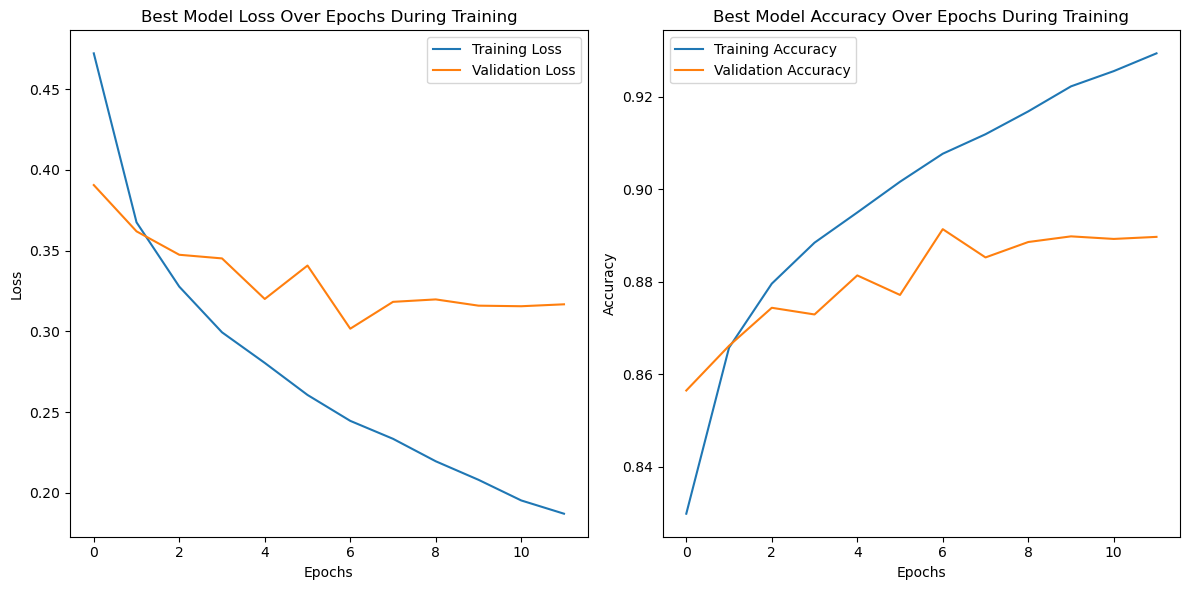

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame 'history_df'
# You can create this DataFrame using pd.DataFrame(history.history)

# Plot the loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Best Model Loss Over Epochs During Training')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Best Model Accuracy Over Epochs During Training')

plt.tight_layout()
plt.show()


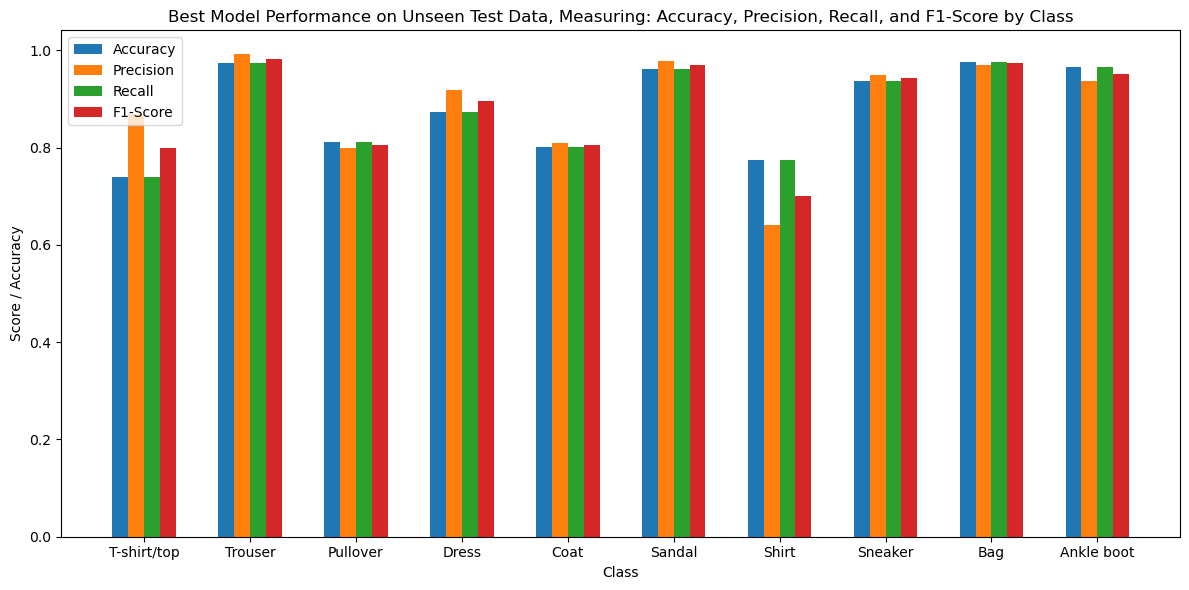

In [47]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Get precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average=None)

# Calculate accuracy for each class
correct_per_class = np.sum((y_test == y_pred_classes) & (y_test == class_indices[:, np.newaxis]), axis=1)
total_per_class = np.bincount(y_test)
accuracy_per_class = correct_per_class / total_per_class

# Define class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create an array of class indices
class_indices = np.arange(len(class_labels))

# Create subplots for accuracy, precision, recall, and F1-score
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.15

# Plot accuracy
ax.bar(class_indices - 1.5 * width, accuracy_per_class, width, label='Accuracy', align='center')
# Plot precision
ax.bar(class_indices - 0.5 * width, precision, width, label='Precision', align='center')
# Plot recall
ax.bar(class_indices + 0.5 * width, recall, width, label='Recall', align='center')
# Plot F1-score
ax.bar(class_indices + 1.5 * width, f1, width, label='F1-Score', align='center')

# Set labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Score / Accuracy')
ax.set_title('Best Model Performance on Unseen Test Data, Measuring: Accuracy, Precision, Recall, and F1-Score by Class')
ax.set_xticks(class_indices)
ax.set_xticklabels(class_labels)
ax.legend()

plt.tight_layout()
plt.show()
